In [ ]:
import transformers
transformers.__version__


In [ ]:
# 1) Instalar dependências
!pip uninstall -y transformers peft accelerate
!pip install -q transformers==4.37.2 accelerate==0.21.0

In [ ]:
# 2) Importações
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [ ]:
# 3) Carregar CSV
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("dataset.csv")

print(df.head())
print(df["classificacao"].value_counts())

In [ ]:
# 4) Preparar labels
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["classificacao"])

num_labels = len(encoder.classes_)
print("Classes:", encoder.classes_)

In [ ]:
# 5) Dividir treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# 6) Tokenização
model_name = "neuralmind/bert-base-portuguese-cased"  # BERT br

tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(
        example["pergunta"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize)
test_dataset = test_dataset.map(tokenize)

train_dataset = train_dataset.remove_columns(["pergunta", "classificacao"])
test_dataset = test_dataset.remove_columns(["pergunta", "classificacao"])

train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

In [ ]:
# 7) Carregar modelo BERT
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

In [ ]:
# 8) Configurar treinamento
training_args = TrainingArguments(
    output_dir="./bert-classificador",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# 9) Treinar o modelo
trainer.train()

In [ ]:
# 10) Avaliação final
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(labels, preds, target_names=encoder.classes_))

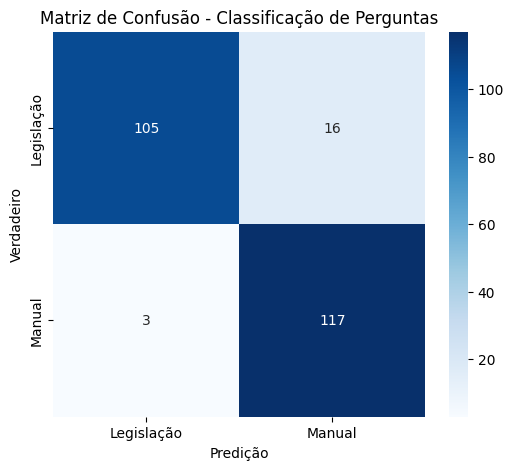

In [ ]:
# 11) Matriz de Confusão
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Classificação de Perguntas")
plt.show()

In [ ]:
import torch

# Garante que estamos usando o mesmo device do modelo (CPU ou GPU)
device = model.device

def classificar_pergunta_bert(pergunta: str):
    # Tokeniza a pergunta
    inputs = tokenizer(
        pergunta,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(device)

    # Faz a previsão
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = int(torch.argmax(logits, dim=-1).item())

    # Converte id numérico para o rótulo original (Manual, Decreto, etc.)
    classe = encoder.inverse_transform([pred_id])[0]

    print(f"Pergunta: {pergunta}")
    print(f"Classe prevista: {classe}")

# Modo interativo:
while True:
    texto = input("Digite uma pergunta (ou deixe vazio para sair): ").strip()
    if not texto:
        print("Encerrando.")
        break
    classificar_pergunta_bert(texto)



Digite uma pergunta (ou deixe vazio para sair): Como registrar corretamente um despacho dentro do e-Docs?
Pergunta: Como registrar corretamente um despacho dentro do e-Docs?
Classe prevista: Manual
Digite uma pergunta (ou deixe vazio para sair): Quais tipos de documentos devem ser assinados eletronicamente?
Pergunta: Quais tipos de documentos devem ser assinados eletronicamente?
Classe prevista: Manual
Digite uma pergunta (ou deixe vazio para sair): Quais métodos de recomposição da Reserva Legal são admitidos pelo Decreto nº 7.830/2012?
Pergunta: Quais métodos de recomposição da Reserva Legal são admitidos pelo Decreto nº 7.830/2012?
Classe prevista: Legislação
Digite uma pergunta (ou deixe vazio para sair): Quais são os documentos necessários para assinar o Termo de Adesão Institucional ao CAR?
Pergunta: Quais são os documentos necessários para assinar o Termo de Adesão Institucional ao CAR?
Classe prevista: Instrução Normativa
Digite uma pergunta (ou deixe vazio para sair): Quais con

In [ ]:
from google.colab import files

files.download('/content/bert_classificador.ipynb')
